In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from sklearn import linear_model, svm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed, Input, Conv1D

In [1]:
import turbo as tb
import rul_dataframe as rd
import plots as pl
import labeling as lb
import preprocessing as pre
import classification as cls

In [4]:
preproc = pre.Preprocessing()
classy = cls.Classification()

In [18]:
def make_model(input_shape, conv_layer = True, n_channels = 32, kernel_size = 5, lstm_dims = [256, 128], dropout = True, d_rate = 0.2, dense_dims = [128, 16, 1]):
    model = Sequential()
    model.add(Input(shape = [None, input_shape], ragged = True))
    if conv_layer:
        model.add(Conv1D(filters = n_channels, kernel_size = kernel_size))
    for d in lstm_dims:
        model.add(LSTM(units = d, return_sequences = True))
    if dropout:
        model.add(Dropout(rate = d_rate))
    for d in dense_dims:
        model.add(Dense(units = d))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [5]:
smoothing = True
for dataset in [1]:
    tr, te, rl = tb.getTFDataset(set = dataset)
    tb.addTFlinear(tr, te, rl)
    tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    te_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    if dataset in [1,3]:
        preproc.drop_zero_variance(rul_df = tr_df, rul_df_test = te_df)
        preproc.scale(rul_df = tr_df, rul_df_test = te_df, scale = 'std')
    elif dataset in [2, 4]:
        classy.fit_kmeans(rul_df = tr_df, rul_df_test = te_df, colname = 'kmeans')
        preproc.one_hot_encode(rul_df = tr_df, rul_df_test = te_df, c_col = 'kmeans')
        preproc.c_drop_zero_variance(rul_df = tr_df, rul_df_test = te_df, c_cols = tr_df.categ_cols)
        preproc.c_scale(rul_df = tr_df, rul_df_test = te_df, c_cols = tr_df.categ_cols, scale = 'std')
    if smoothing:
        preproc.moving_average(rul_df = tr_df, shift = 10)
        preproc.moving_average(rul_df = te_df, shift = 10)
    else:
        preproc.delete_first_n(tr_df, 9)
    labels = pd.read_csv(f'labels/FD00{dataset}')
    label_cols = ['linear', 'piecewise_optimized', 'piecewise_100', 'piecewise_110',
                    'piecewise_120', 'piecewise_130', 'descriptive', 'spearman', 'rec_error']
    if not labels.shape[0] == tr_df.df.shape[0]:
        print(f'Labels and Data do not have same length. Dataset FD00{dataset}')
        break

    Xtrain = np.asarray(tr_df.df[tr_df.data_cols])
    Xtest = np.asarray(te_df.df[te_df.data_cols])
    if not Xtrain.shape[1] == Xtest.shape[1]:
        print(f'Train and test data do not have same columns. Dataset FD00{dataset}')
        break
    Ytest =  np.asarray(te_df.df['linear'])
    # create ragged tensors
    Xtrain_ragged = tf.RaggedTensor.from_value_rowids(
                    values = Xtrain,
                    value_rowids = (tr_df.df[tr_df.id_col] - 1))
    Xtest_ragged = tf.RaggedTensor.from_value_rowids(
                    values = Xtest,
                    value_rowids = (te_df.df[te_df.id_col] - 1)) 
    Ytest_ragged = tf.RaggedTensor.from_value_rowids(
                    values = Ytest,
                    value_rowids = (te_df.df[te_df.id_col] - 1))

    # for label in ['piecewise_optimized']:
    #     Ytrain = np.asarray(labels[label])
    #     Ytrain_ragged = tf.RaggedTensor.from_value_rowids(
    #                 values = Ytrain,
    #                 value_rowids = (tr_df.df[tr_df.id_col] - 1))
        
    #     model = make_model(input_shape = Xtrain.shape[1])
        
    #     model.fit(Xtrain_ragged, Ytrain_ragged,
    #                 validation_split = 0.2,
    #                 epochs = 50,
    #                 batch_size = 3)

In [12]:
Xtrain.shape

(19731, 14)

In [6]:
Xtrain_ragged.shape

TensorShape([100, None, 14])

In [10]:
Xtrain.shape

(19731, 14)

In [2]:
train, test = getTFData(sets = [4])
train = addSettings(train)
test = addSettings(test)
train = train.drop(columns = ['set1', 'set2', 'set3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'])
test = test.drop(columns = ['set1', 'set2', 'set3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'])
sensors = train.columns.drop(['id', 'dt', 'rul', 'rulfrac', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6'])
train, test = cScale(train, test, sensors = sensors)

In [3]:
Xtrain = train.drop(columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'id', 'dt', 'rul', 'rulfrac'])
Xtest = test.drop(columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'id', 'dt', 'rul', 'rulfrac'])

In [4]:
Xtrain = np.asarray(Xtrain)
Xtest = np.asarray(Xtest)

In [5]:
Ytrain = np.asarray(train['rul'])
Ytest = np.asarray(test['rul'])

In [6]:
Ytrain = np.expand_dims(Ytrain, axis = 1)
Ytest = np.expand_dims(Ytest, axis = 1)

In [7]:
Xtrain_ragged = tf.RaggedTensor.from_value_rowids(
                    values = Xtrain,
                    value_rowids = (train.id - 1))

In [8]:
Xtest_ragged = tf.RaggedTensor.from_value_rowids(
                    values = Xtest,
                    value_rowids = (test.id - 1))

In [9]:
Ytrain_ragged = tf.RaggedTensor.from_value_rowids(
                    values = Ytrain,
                    value_rowids = (train.id - 1))

In [10]:
Ytest_ragged = tf.RaggedTensor.from_value_rowids(
                    values = test.rul,
                    value_rowids = (test.id - 1))

# ToDo

New loss function, why?:
- worse if estimate too large than small for rul context
- bad predicitons for end of life worse

\begin{equation}
loss(\alpha,\beta) = 
    \begin{cases}
    \sum_i \frac{y_i - \hat{y_i}}{\beta \cdot y_i} & \quad \text{if } y_i > \hat{y_i}\\
    \sum_i \alpha \cdot \frac{\hat{y_i} - y_i}{\beta \cdot y_i} & \quad \text{if } y_i < \hat{y_i}
  \end{cases}
\end{equation}

- where $\alpha$ larger means penalty on too high prediciton
- $\beta$ penalizes low true rul

In [ ]:
import keras.backend as kb
class InversWeightAsymmetryLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def scale(y_true, y_pred):
        loss1 = 
        loss2
    def call(self, y_true, y_pred):
        

In [ ]:
def InversWeightAsymmetryLoss(y_true, y_pred):
    

In [12]:
simpleLSTM = Sequential([
    Input(shape = [None, 14], ragged = True),
    Dense(32),
    LSTM(16, return_sequences = True),
    Dense(8),
    Dense(1)])

In [13]:
simpleLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 32)          480       
                                                                 
 lstm (LSTM)                 (None, None, 16)          3136      
                                                                 
 dense_1 (Dense)             (None, None, 8)           136       
                                                                 
 dense_2 (Dense)             (None, None, 1)           9         
                                                                 
Total params: 3,761
Trainable params: 3,761
Non-trainable params: 0
_________________________________________________________________


In [14]:
simpleLSTM.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
simpleLSTM.fit(Xtrain_ragged, Ytrain_ragged,
                    epochs = 30,
                    batch_size = 3)

Epoch 1/30
Instructions for updating:
Use fn_output_signature instead


c:\users\jakob\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


83/83 [==============================] - 9s 80ms/step - loss: 23930.5449
Epoch 2/30
83/83 [==============================] - 7s 80ms/step - loss: 21444.8496
Epoch 3/30
83/83 [==============================] - 7s 80ms/step - loss: 18100.3672
Epoch 4/30
83/83 [==============================] - 8s 91ms/step - loss: 15088.8877
Epoch 5/30
83/83 [==============================] - 8s 96ms/step - loss: 12081.7607
Epoch 6/30
83/83 [==============================] - 8s 95ms/step - loss: 9547.3643
Epoch 7/30
83/83 [==============================] - 8s 96ms/step - loss: 7605.8149
Epoch 8/30
83/83 [==============================] - 8s 96ms/step - loss: 6099.2925
Epoch 9/30
83/83 [==============================] - 8s 98ms/step - loss: 5139.9849
Epoch 10/30
83/83 [==============================] - 8s 98ms/step - loss: 4517.1533
Epoch 11/30
83/83 [==============================] - 8s 98ms/step - loss: 4069.1628
Epoch 12/30
83/83 [==============================] - 8s 95ms/step - loss: 3744.3149
Epoch 1

In [16]:
simpleLSTM.fit(Xtrain_ragged, Ytrain_ragged,
                    epochs = 30,
                    batch_size = 3)

Epoch 1/30
83/83 [==============================] - 7s 85ms/step - loss: 3066.7107
Epoch 2/30
83/83 [==============================] - 8s 95ms/step - loss: 2930.5320
Epoch 3/30
83/83 [==============================] - 8s 97ms/step - loss: 3037.5471
Epoch 4/30
83/83 [==============================] - 8s 97ms/step - loss: 3138.6860
Epoch 5/30
83/83 [==============================] - 8s 96ms/step - loss: 3009.8481
Epoch 6/30
83/83 [==============================] - 8s 99ms/step - loss: 3012.3782
Epoch 7/30
83/83 [==============================] - 8s 95ms/step - loss: 2943.0073
Epoch 8/30
83/83 [==============================] - 8s 97ms/step - loss: 3027.1030
Epoch 9/30
83/83 [==============================] - 8s 95ms/step - loss: 2924.1597
Epoch 10/30
83/83 [==============================] - 8s 94ms/step - loss: 2964.2805
Epoch 11/30
83/83 [==============================] - 8s 97ms/step - loss: 2931.9932
Epoch 12/30
83/83 [==============================] - 8s 95ms/step - loss: 2974.8159
E

In [17]:
Yhat_train_ragged = simpleLSTM.predict(Xtrain_ragged)

In [18]:
Yhat_train_ragged.shape

TensorShape([249, None, 1])

In [147]:
Ytrain_ragged.shape

TensorShape([249, None, 1])

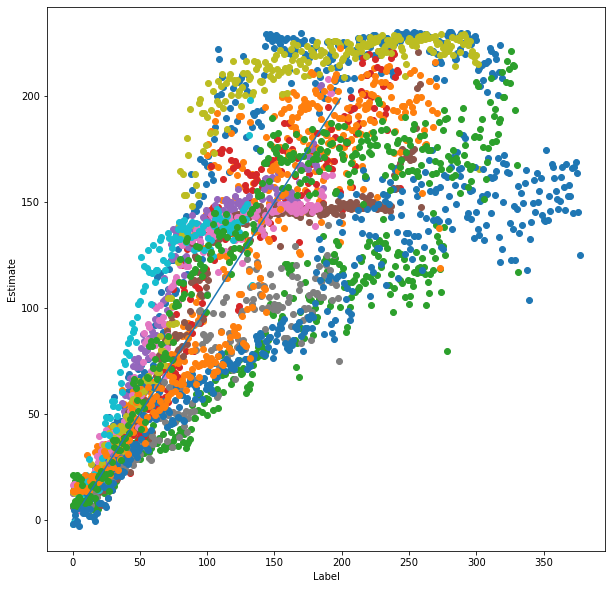

In [19]:
plt.figure(figsize=(10,10))
for i in range(249):
    if i % 20 == 0:
        y1 = np.squeeze(Yhat_train_ragged[i])
        y2 = np.squeeze(Ytrain_ragged[i])
        plt.scatter(y2,y1)
plt.xlabel('Label')
plt.ylabel('Estimate')
plt.plot(range(200))
plt.show()

In [20]:
Yhat_test_ragged = simpleLSTM.predict(Xtest_ragged)

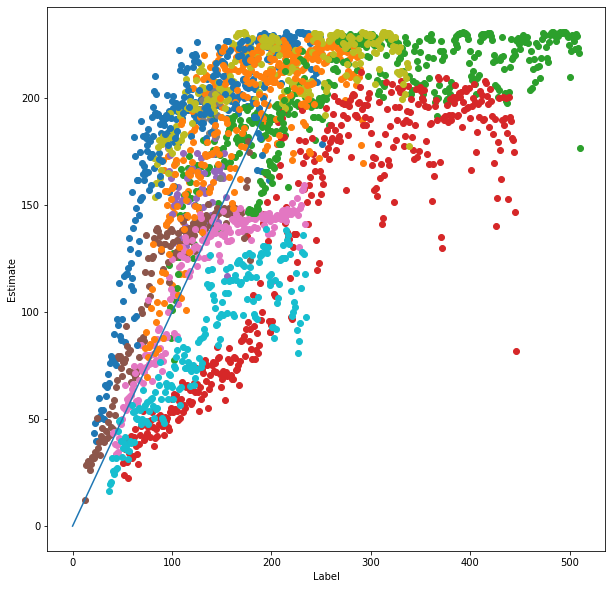

In [21]:
plt.figure(figsize=(10,10))
for i in range(249):
    if i % 20 == 0:
        y1 = np.squeeze(Yhat_test_ragged[i])
        y2 = np.squeeze(Ytest_ragged[i])
        plt.scatter(y2,y1)
plt.xlabel('Label')
plt.ylabel('Estimate')
plt.plot(range(200))
plt.show()

In [11]:
biggerLSTM = Sequential([
    Input(shape = [None, 14], ragged = True),
    Dense(32),
    LSTM(32, return_sequences = True),
    LSTM(16, return_sequences = True),
    Dense(8),
    Dense(1)])

In [12]:
biggerLSTM.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
biggerLSTM.fit(Xtrain_ragged, Ytrain_ragged,
                    epochs = 30,
                    batch_size = 3)

Epoch 1/30
83/83 [==============================] - 15s 180ms/step - loss: 2074.7185
Epoch 2/30
83/83 [==============================] - 16s 188ms/step - loss: 1970.6477
Epoch 3/30
83/83 [==============================] - 16s 188ms/step - loss: 2067.3455
Epoch 4/30
83/83 [==============================] - 16s 189ms/step - loss: 1969.0825
Epoch 5/30
83/83 [==============================] - 16s 192ms/step - loss: 1992.2959
Epoch 6/30
83/83 [==============================] - 16s 189ms/step - loss: 1908.5253
Epoch 7/30
83/83 [==============================] - 18s 218ms/step - loss: 1952.3579
Epoch 8/30
83/83 [==============================] - 16s 190ms/step - loss: 1916.3689
Epoch 9/30
83/83 [==============================] - 16s 186ms/step - loss: 1881.6418
Epoch 10/30
83/83 [==============================] - 17s 207ms/step - loss: 1906.0154
Epoch 11/30
83/83 [==============================] - 16s 188ms/step - loss: 1880.6263
Epoch 12/30
83/83 [==============================] - 16s 187ms/

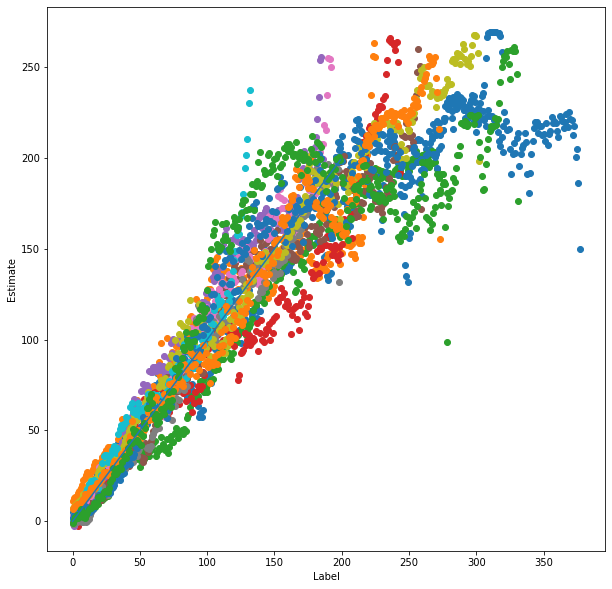

In [16]:
Yhat_train_ragged_2 = biggerLSTM.predict(Xtrain_ragged)
plt.figure(figsize=(10,10))
for i in range(249):
    if i % 20 == 0:
        y1 = np.squeeze(Yhat_train_ragged_2[i])
        y2 = np.squeeze(Ytrain_ragged[i])
        plt.scatter(y2,y1)
plt.xlabel('Label')
plt.ylabel('Estimate')
plt.plot(range(200))
plt.show()

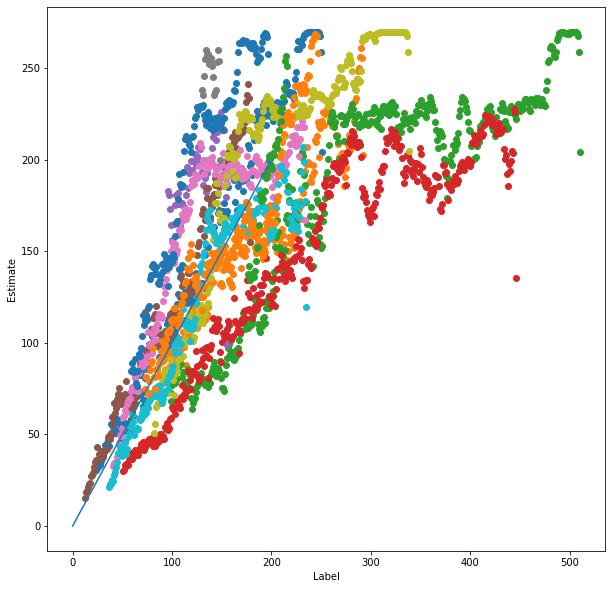

In [17]:
Yhat_test_ragged_2 = biggerLSTM.predict(Xtest_ragged)
plt.figure(figsize=(10,10))
for i in range(249):
    if i % 20 == 0:
        y1 = np.squeeze(Yhat_test_ragged_2[i])
        y2 = np.squeeze(Ytest_ragged[i])
        plt.scatter(y2,y1)
plt.xlabel('Label')
plt.ylabel('Estimate')
plt.plot(range(200))
plt.show()

# Predict 'successively'

In [193]:
id_number = 11
trajectory = test[test['id'] == id_number].copy()

In [177]:
Yhat = []

,id,dt,s2,s3,s4,s7,s8,s9,s11,s12,...,s20,s21,rul,rulfrac,c1,c2,c3,c4,c5,c6
1538,11,1,-0.755274,-0.679712,-0.710624,0.305311,-0.444403,-0.295251,-0.393933,0.340814,...,-0.034578,0.519554,224,1.000000,0,1,0,0,0,0
1539,11,2,-1.244619,0.134516,-0.399258,0.667769,-0.147291,-0.284095,-1.346055,0.267416,...,0.566028,0.646631,223,0.995536,0,0,0,0,0,1
1540,11,3,0.114914,-0.627703,-0.598821,0.456565,-0.665234,-0.480506,-0.257094,0.193479,...,0.693969,1.341780,222,0.991071,0,1,0,0,0,0
1541,11,4,-1.451703,-0.448667,-0.757287,0.016115,-0.769320,-0.363897,-0.845901,-0.070707,...,0.564703,0.844791,221,0.986607,1,0,0,0,0,0
1542,11,5,-1.140654,-0.474015,-0.419205,0.160292,-0.365281,-0.311484,-0.778255,0.173230,...,0.919269,0.825087,220,0.982143,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,11,78,-0.792353,0.075390,-0.516786,0.416761,0.062054,-0.252254,-1.068035,0.884737,...,1.493220,-0.676018,147,0.656250,0,0,0,0,0,1
1616,11,79,-0.136474,-0.538981,-1.272834,0.683446,-0.554819,-0.363530,-0.667613,0.488149,...,1.058242,1.506398,146,0.651786,0,1,0,0,0,0
1617,11,80,0.375712,-1.067454,-1.804415,0.465946,-0.230602,-0.644125,-1.387069,0.365330,...,0.604100,1.167287,145,0.647321,1,0,0,0,0,0
1618,11,81,-0.639249,-0.921401,-0.674421,0.238087,-0.278780,-0.318540,-1.112342,0.247055,...,0.902125,1.103516,144,0.642857,0,1,0,0,0,0


In [194]:
trajectory = trajectory.reset_index()
trajectory = trajectory.drop(columns = ['index','id','dt','rul','rulfrac','c1','c2','c3','c4','c5','c6'])

In [196]:
x = np.asarray(trajectory.iloc[[0]])

In [199]:
x = np.expand_dims(x, axis = 1)

In [201]:
x.shape

(1, 1, 14)

In [202]:
y0 = simpleLSTM.predict(x)

In [203]:
y0

array([[[148.65274]]], dtype=float32)

In [46]:
def plts_all(s):
    plt.figure(figsize=(15,5))
    for i in train['id'].unique():
        plt.plot('rul', s, data=train[train['id'] == i])
    plt.xlim(560, -10)
    plt.xticks(np.arange(0, 600, 25))
    plt.ylabel(s)
    plt.xlabel('Remaining Useful Life')
    plt.show()

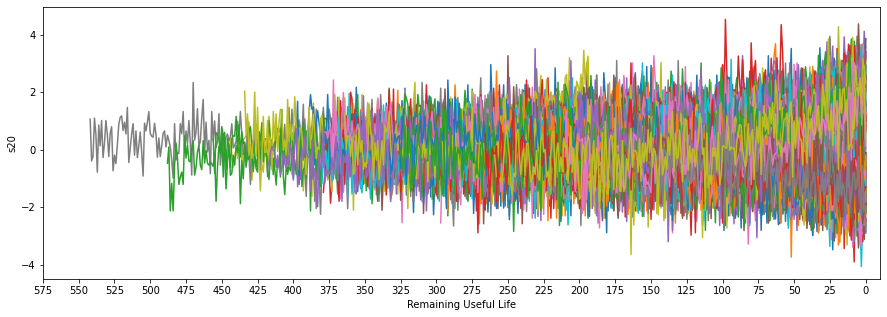

In [47]:
plts_all('s20')

In [31]:
def plts(s, i):
    plt.figure(figsize=(15,5))
    plt.plot('dt', s, data=train[train['id'] == i])
    plt.ylabel(s)
    plt.xlabel('Time')
    plt.show()

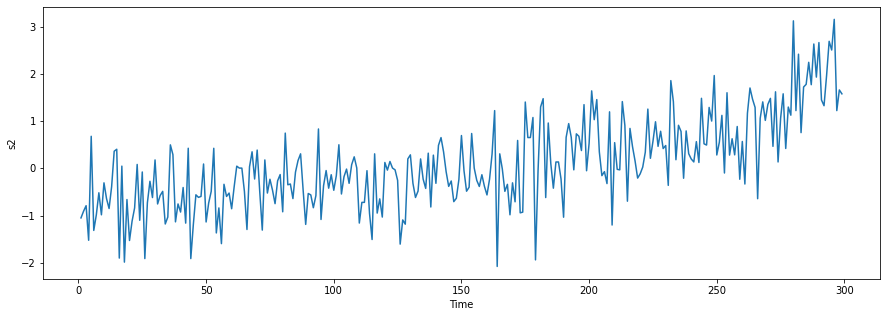

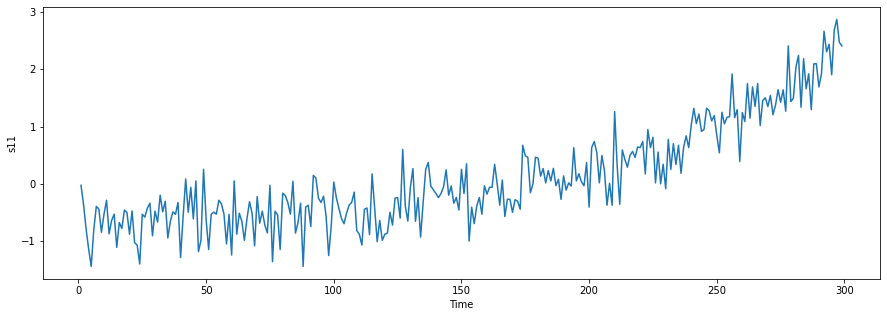

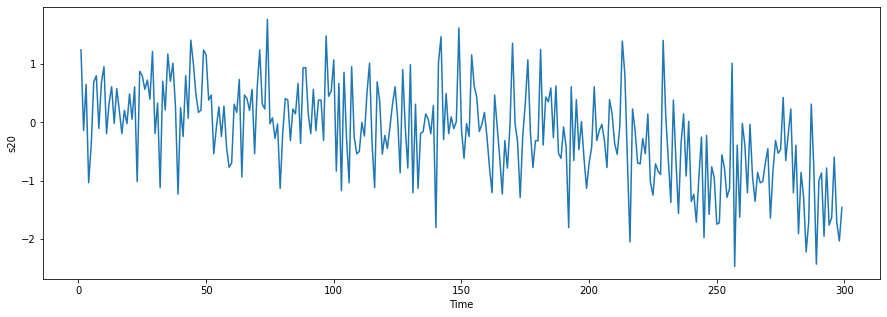

In [34]:
plts('s2', 2)
plts('s11', 2)
plts('s20', 2)